# BiGAN (Bidirectional Gan)

This is an attempt to re-implement the paper BiGAN

Paper: https://arxiv.org/pdf/1605.09782.pdf

Other Resources: 
* https://www.youtube.com/watch?v=2tNMIlTOq8k

In [1]:
import numpy as np
from glob import glob
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
num_images = 10000
batch_size = 64
img_shape = (128, 128, 3)

In [3]:
def load_files(files):
    images = tf.io.decode_png(tf.io.read_file(files), channels = 3)
    
    images = tf.image.resize(images, img_shape[:-1], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    images = tf.cast(images, tf.float32)
    images = (images/127.5) - 1
    return images

In [4]:
path = 'E:\\Image Datasets\\Celeb A\\Dataset\\img_align_celeba\\img_align_celeba'
files = glob(path+'\\*.jpg')[:num_images]
dataset = tf.data.Dataset.list_files(files).map(load_files).shuffle(num_images).batch(batch_size, drop_remainder = True)
dataset

<BatchDataset shapes: (64, 128, 128, 3), types: tf.float32>

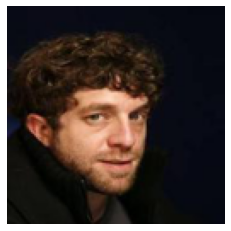

In [5]:
idx = int(np.random.uniform(low = 0, high = num_images))
plt.imshow(np.array(Image.open(files[idx]).resize([128, 128])))
plt.axis('off')
plt.show()

In [6]:
class GAN(object):
    '''
        Model Architectures for encoder, generator & discriminator Does not matter much, 
        any type of architecture would work. Anyone interested in changing the model, should change and
        experiment with it.
    '''
    def __init__(self, img_shape = img_shape, latent_dim = 64):
        self.img_shape = img_shape
        self.latent_dim = latent_dim
        
    def res_block(self, inp, inp_filters, out_filters, kernel_size = (3, 3), strides = (1, 1), padding = 'same', 
                  adjust_type = None):
        
        x = tf.keras.layers.Conv2D(filters = inp_filters, kernel_size = kernel_size, strides = strides, 
                                   padding = padding)(inp)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        x = tf.keras.layers.Conv2D(filters = inp_filters, kernel_size = kernel_size, strides = strides, 
                                   padding = padding)(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        x = tf.keras.layers.Add()([x, inp])
        
        if adjust_type is None:
            return x
        
        elif adjust_type == 'down':
            x = tf.keras.layers.Conv2D(filters = out_filters, kernel_size = kernel_size, strides = (2, 2), 
                                   padding = padding)(x)
            x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
            x = tf.keras.layers.BatchNormalization()(x)
            
        elif adjust_type == 'up':
            x = tf.keras.layers.UpSampling2D(size = (2, 2), interpolation = 'bilinear')(x)
            x = tf.keras.layers.Conv2D(filters = out_filters, kernel_size = kernel_size, strides = strides, 
                                   padding = padding)(x)
            x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
            x = tf.keras.layers.BatchNormalization()(x)
            
        return x
        
    @property
    def encoder(self):
        inp = tf.keras.layers.Input(shape = self.img_shape, dtype = tf.float32, name = f'encode_input_{self.img_shape}')

        # 128x128x8
        x = tf.keras.layers.Conv2D(filters = 8, kernel_size = (1, 1), strides = (1, 1), padding = 'same')(inp)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        # 128x128x16
        x = self.res_block(inp = x, inp_filters = 8, out_filters = 16, adjust_type = 'down')# 64x64x32
        x = self.res_block(inp = x, inp_filters = 16, out_filters = 32, adjust_type = 'down')# 32x32x64
        x = self.res_block(inp = x, inp_filters = 32, out_filters = 64, adjust_type = 'down')# 16x16x128
        x = self.res_block(inp = x, inp_filters = 64, out_filters = 128, adjust_type = 'down')# 8x8x256
        x = self.res_block(inp = x, inp_filters = 128, out_filters = 256, adjust_type = 'down')# 4x4x512

        # 4x4x512
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(units = self.latent_dim)(x)

        return tf.keras.models.Model(inp, x, name = 'Encoder')
    
    @property
    def generator(self):
        inp = tf.keras.layers.Input(shape = self.latent_dim, dtype = tf.float32, 
                                    name = f'generator_input{self.latent_dim}')
        
        x = tf.keras.layers.Dense(units = 4*4*256)(inp)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        x = tf.keras.layers.Reshape((4, 4, 256))(x)
        
        x = self.res_block(inp = x, inp_filters = 256, out_filters = 128, adjust_type = 'up')
        x = self.res_block(inp = x, inp_filters = 128, out_filters = 64, adjust_type = 'up')
        x = self.res_block(inp = x, inp_filters = 64, out_filters = 32, adjust_type = 'up')
        x = self.res_block(inp = x, inp_filters = 32, out_filters = 16, adjust_type = 'up')
        
        x = tf.keras.layers.UpSampling2D(size = (2, 2), interpolation = 'bilinear')(x)
        x = tf.keras.layers.Conv2D(filters = 3, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(x)
        x = tf.keras.layers.Activation('tanh')(x)
        
        return tf.keras.models.Model(inp, x, name = 'Generator')
    
    @property
    def discriminator(self):
        inp_img = tf.keras.layers.Input(shape = self.img_shape, dtype = tf.float32, 
                                        name = f'discriminator_img_input_{self.img_shape}')
        inp_latent = tf.keras.layers.Input(shape = self.latent_dim, dtype = tf.float32, 
                                           name = f'discriminator_latent_input_{self.latent_dim}')
        
        # 128x128x3
        x = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(inp_img)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        x = tf.keras.layers.BatchNormalization()(x)

        # 64x64x16
        x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        x = tf.keras.layers.BatchNormalization()(x)

        # 32x32x32
        x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        x = tf.keras.layers.BatchNormalization()(x)

        # 16x16x64
        x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        x = tf.keras.layers.BatchNormalization()(x)

        # 8x8x128
        x = tf.keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        x = tf.keras.layers.BatchNormalization()(x)

        # 4x4x256
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(units = self.latent_dim)(x)
        
        
        
        x = tf.keras.layers.Concatenate()([x, inp_latent])
        
        x = tf.keras.layers.Dense(units = 64)(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        x = tf.keras.layers.Dense(units = 32)(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        x = tf.keras.layers.Dense(units = 16)(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        x = tf.keras.layers.Dense(units = 1)(x)
        
        return tf.keras.models.Model([inp_img, inp_latent], x, name = 'Discriminator')

In [7]:
gan = GAN()
encoder = gan.encoder
generator = gan.generator
discriminator = gan.discriminator

In [8]:
encoder.summary()
generator.summary()
discriminator.summary()

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encode_input_(128, 128, 3) (Inp [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 8)  32          encode_input_(128, 128, 3)[0][0] 
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 8)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  584         leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [9]:
class Losses(object):
    def __init__(self):
        self.bce = tf.keras.losses.BinaryCrossentropy(from_logits = True)
    
    def gradient_penalty(self, disc, real, gen, real_z, gen_z, gp_weight = 10):
        epsilon = tf.random.uniform((real.shape[0], 1, 1, 1), minval = 0.0, maxval = 1.0)
        interpolated = ((1 - epsilon) * real) + (epsilon * gen)
        interpolated_z = ((1 - epsilon[:, :, 0, 0]) * real_z) + (epsilon[:, :, 0, 0] * gen_z)
        
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            out = disc([interpolated, interpolated_z])
        grads = gp_tape.gradient(out, [interpolated])[0]
        norm = tf.math.sqrt(tf.math.reduce_mean(tf.math.square(grads), axis = [1, 2, 3], keepdims = True))
        gp = tf.math.reduce_mean(tf.square(norm - 1))

        return gp * gp_weight

    def disc_wgan_loss(self, disc_real_out, disc_gen_out):
        return tf.math.reduce_mean(disc_gen_out) - tf.math.reduce_mean(disc_real_out)

    def gen_wgan_loss(self, disc_gen_out):
        return -tf.math.reduce_mean(disc_gen_out)
    
    def disc_bce_loss(self, disc_real_out, disc_gen_out):
        real_loss = self.bce(tf.ones_like(disc_real_out), disc_real_out)
        gen_loss = self.bce(tf.zeros_like(disc_gen_out), disc_gen_out)
        return real_loss + gen_loss
    
    def gen_bce_loss(self, disc_gen_out, disc_real_out):
        gen_loss = self.bce(tf.ones_like(disc_gen_out), disc_gen_out)
        real_loss = self.bce(tf.zeros_like(disc_real_out), disc_real_out)
        return gen_loss + real_loss

In [10]:
class Train(object):
    def __init__(self, gan_class, img_shape = img_shape, latent_dim = 64, n_disc = 1, learning_rate = 1e-4):
        self.n_disc = n_disc
        self.latent_dim = latent_dim
        self.enc_gen_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.0, beta_2 = 0.9)
        # self.gen_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.0, beta_2 = 0.9)
        self.disc_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.0, beta_2 = 0.9)
        
        self.gan = gan_class(img_shape = img_shape, latent_dim = latent_dim)
        self.encoder = self.gan.encoder
        self.generator = self.gan.generator
        self.discriminator = self.gan.discriminator
        
        self.loss = Losses()
        
        assert self.encoder.input_shape == self.generator.output_shape
        assert self.generator.input_shape == self.encoder.output_shape
        
    def discriminator_loss(self, disc_real_out, disc_gen_out, real_img, gen_img, real_z, gen_z, gp_weight = 10):
        disc_wgan_loss = self.loss.disc_wgan_loss(disc_real_out, disc_gen_out)
        disc_bce_loss = self.loss.disc_bce_loss(disc_real_out, disc_gen_out)
        gradient_penalty = self.loss.gradient_penalty(self.discriminator, real_img, gen_img, real_z, gen_z, 
                                                      gp_weight = gp_weight)
        disc_loss = disc_wgan_loss + disc_bce_loss + gradient_penalty
        return disc_loss
    
    def encoder_generator_loss(self, disc_gen_out, disc_real_out):
        gen_wgan_loss = self.loss.gen_wgan_loss(disc_gen_out)
        gen_bce_loss = self.loss.gen_bce_loss(disc_gen_out, disc_real_out)
        enc_gen_loss = gen_wgan_loss + gen_bce_loss
        return enc_gen_loss
        
    def train(self, data, epochs = 1):
        enc_gen_losses, disc_losses = [], []
        for e in range(epochs):
            print(f'Epoch: {e} Starts')
            for img_inp in data:
                enc_gen_loss, disc_loss = self.train_step(img_inp)
                print('.', end='')
                
            enc_gen_losses.append(enc_gen_loss)
            disc_losses.append(disc_loss)
            print(f'\nEncoder-Generator Loss: {enc_gen_loss} \t Discriminator Loss: {disc_loss}')
            print(f'Epoch: {e} Ends\n')
        return enc_gen_losses, disc_losses
    
    def generate_latent(self, batch_size):
        return tf.random.normal(shape = (batch_size, self.latent_dim), mean = 0.0, stddev = 1.0)
        
    @tf.function
    def train_step(self, real_img):
        
        latent_noise = self.generate_latent(real_img.shape[0])
        for _ in range(self.n_disc):
            with tf.GradientTape() as disc_tape:
                enc_out = self.encoder(real_img, training = True)
                gen_out = self.generator(latent_noise, training = True)
                
                disc_real_out = self.discriminator([real_img, enc_out], training = True)
                disc_gen_out = self.discriminator([gen_out, latent_noise], training = True)
                
                disc_loss = self.discriminator_loss(disc_real_out, disc_gen_out, real_img, gen_out, 
                                                    enc_out, latent_noise, gp_weight = 10)
                
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
            self.disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        with tf.GradientTape() as enc_gen_tape:
            enc_out = self.encoder(real_img, training = True)
            gen_out = self.generator(latent_noise, training = True)
            
            disc_real_out = self.discriminator([real_img, enc_out], training = True)
            disc_gen_out = self.discriminator([gen_out, latent_noise], training = True)
            
            enc_gen_loss = self.encoder_generator_loss(disc_gen_out, disc_real_out)
            
        enc_gen_params = self.encoder.trainable_variables + self.generator.trainable_variables
        enc_gen_grads = enc_gen_tape.gradient(enc_gen_loss, enc_gen_params)
        self.enc_gen_optimizer.apply_gradients(zip(enc_gen_grads, enc_gen_params))
        
        return enc_gen_loss, disc_loss

In [11]:
trainer = Train(GAN)

In [12]:
training_losses = trainer.train(dataset, epochs = 1)

Epoch: 0 Starts
............................................................................................................................................................
Encoder-Generator Loss: 1.3953965902328491 	 Discriminator Loss: 11.142580032348633
Epoch: 0 Ends



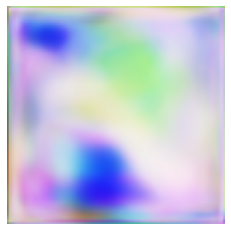

In [13]:
plt.imshow(((trainer.generator(trainer.encoder(next(iter(dataset)))) + 1)*127.5).numpy().astype('uint8')[0])
plt.axis('off')
plt.show()